## Generador y discriminador

Funciones de perdida

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Tamaño de la capa de codificación
tamanio_codificacion = 100

# Generador
generador = Sequential()
generador.add(Dense(100, activation="relu", input_shape=[tamanio_codificacion]))
generador.add(Dense(150, activation='relu'))
generador.add(Dense(128 * 128 * 3, activation="sigmoid"))
generador.add(Reshape([128, 128, 3]))  # Esto es lo que espera el discriminador
print('Generador construido')

# Discriminador
discriminador = Sequential()
discriminador.add(Flatten(input_shape=[128, 128, 3]))
discriminador.add(Dense(150, activation='relu'))
discriminador.add(Dense(100, activation='relu'))
discriminador.add(Dense(1, activation="sigmoid"))
print('Discriminador construido')

discriminador.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002))

# GAN
GAN = Sequential([generador, discriminador])
discriminador.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002))
print('GAN compilada')

# Función para cargar y preprocesar las imágenes en lotes
def cargar_imagenes(data_dir, batch_size):
    for filename in os.listdir(data_dir):
        img = plt.imread(os.path.join(data_dir, filename))
        if img is not None:
            img = (img - 127.5) / 127.5  # Escalar las imágenes al rango [-1, 1]
            yield img

# Configuración
data_dir = './img_preprocesadas/'  # Cambia esto a tu directorio
batch_size = 32
total_epochs = 10  # Reducido el número de épocas
output_dir = 'img_generadas'  # Carpeta para guardar las imágenes generadas
os.makedirs(output_dir, exist_ok=True)  # Crea la carpeta si no existe

# Entrenamiento de la GAN
for epoch in range(total_epochs):
    print(f"Época {epoch + 1}/{total_epochs}")
    
    # Cargar y preprocesar las imágenes en lotes en cada época
    datos = tf.data.Dataset.from_generator(
        lambda: cargar_imagenes(data_dir, batch_size),
        output_signature=tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32)
    )
    datos = datos.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)
    
    for i, batch in enumerate(datos):
        ruido = tf.random.normal(shape=[batch_size, tamanio_codificacion])
        
        # Fase 1 - Entrenamiento del Discriminador
        imagenes_generadas = generador(ruido)
        imagenes_completas = tf.concat([imagenes_generadas, batch], axis=0)
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        discriminador.trainable = True
        discriminador.train_on_batch(imagenes_completas, y1)
        
        # Fase 2 - Entrenamiento del Generador
        y2 = tf.constant([[1.]] * batch_size)
        discriminador.trainable = False
        GAN.train_on_batch(ruido, y2)
    
    # Guardar imágenes generadas al final de cada época
    if (epoch + 1) % 10 == 0:
        ruido = tf.random.normal(shape=[10, tamanio_codificacion])
        imagenes_generadas = generador(ruido)
        for i, imagen in enumerate(imagenes_generadas):
            plt.imsave(os.path.join(output_dir, f'imagen_generada_epoch_{epoch + 1}_imagen_{i}.png'), (imagen + 1) / 2.0)

print("Entrenamiento Completado")


Generador construido
Discriminador construido
GAN compilada
Época 1/10


ValueError: Data cardinality is ambiguous:
  x sizes: 39
  y sizes: 64
Make sure all arrays contain the same number of samples.

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Establecer las semillas aleatorias para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Directorio que contiene las imágenes preprocesadas
data_directory = "img_preprocesadas"

# Tamaño de las imágenes y del código de entrada al generador
image_size = (128, 128, 3)
tamanio_codificacion = 100

# Cargar las imágenes desde el directorio
datagen = ImageDataGenerator(rescale=1.0/255)
data_generator = datagen.flow_from_directory(
    data_directory,
    target_size=image_size[:2],
    batch_size=32,
    class_mode=None  # No se necesita etiqueta, solo las imágenes
)

# Generador
generador = Sequential()
generador.add(Dense(256, activation="relu", input_shape=[tamanio_codificacion]))
generador.add(Dense(512, activation="relu"))
generador.add(Dense(1024, activation="relu"))
generador.add(Dense(np.prod(image_size), activation="sigmoid"))  # Capa de salida
generador.add(Reshape(image_size))  # Cambiar la forma para que coincida con el tamaño de la imagen

# Discriminador
discriminador = Sequential()
discriminador.add(Flatten(input_shape=image_size))
discriminador.add(Dense(1024, activation="relu"))
discriminador.add(Dense(512, activation="relu"))
discriminador.add(Dense(256, activation="relu"))
discriminador.add(Dense(1, activation="sigmoid"))

discriminador.compile(loss="binary_crossentropy", optimizer="adam")

# GAN
discriminador.trainable = False
GAN = Sequential([generador, discriminador])
GAN.compile(loss="binary_crossentropy", optimizer="adam")

# Resumen de la GAN
GAN.summary()

# Entrenamiento
epocas = 1  # Número de épocas (solo una para este ejemplo)

for epoca in range(epocas):
    print(f"Época {epoca + 1}")
    i = 0
    for X_tanda in data_generator:
        i += 1
        if i % 100 == 0:
            print(f"Tanda {i} de {len(data_generator)}")
        
        # Fase 1 - Entrenamiento del Discriminador
        ruido = tf.random.normal(shape=[X_tanda.shape[0], tamanio_codificacion])
        imagenes_gen = generador(ruido)
        X_falso_vs_real = tf.concat([imagenes_gen, X_tanda], axis=0)
        y1 = tf.constant([[0.]] * X_tanda.shape[0] + [[1.]] * X_tanda.shape[0])
        
        discriminador.trainable = True
        discriminador.train_on_batch(X_falso_vs_real, y1)
        
        # Fase 2 - Entrenamiento del Generador
        ruido = tf.random.normal(shape=[X_tanda.shape[0], tamanio_codificacion])
        y2 = tf.constant([[1.]] * X_tanda.shape[0])
        
        discriminador.trainable = False
        GAN.train_on_batch(ruido, y2)

print("Entrenamiento completado")

# Generar una imagen nueva
nueva_imagen = generador.predict(np.random.normal(size=[1, tamanio_codificacion]))[0]

# Mostrar la imagen generada
plt.imshow(nueva_imagen)
plt.axis("off")
plt.show()


Found 0 images belonging to 0 classes.
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 128, 128, 3)       51063552  
                                                                 
 sequential_16 (Sequential)  (None, 1)                 50989057  
                                                                 
Total params: 102,052,609
Trainable params: 51,063,552
Non-trainable params: 50,989,057
_________________________________________________________________
Época 1
Tanda 100 de 0
Tanda 200 de 0
Tanda 300 de 0
Tanda 400 de 0
Tanda 500 de 0
Tanda 600 de 0
Tanda 700 de 0
Tanda 800 de 0
Tanda 900 de 0
Tanda 1000 de 0
Tanda 1100 de 0
Tanda 1200 de 0
Tanda 1300 de 0
Tanda 1400 de 0
Tanda 1500 de 0
Tanda 1600 de 0
Tanda 1700 de 0
Tanda 1800 de 0
Tanda 1900 de 0
Tanda 2000 de 0
Tanda 2100 de 0
Tanda 2200 de 0
Tanda 2300 de 0
Tanda 2400 de 0
Tanda

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os
from PIL import Image
import glob

# Configura la semilla aleatoria para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Definir el tamaño del código de entrada para el generador
tamanio_codificacion = 100

# Carga y preprocesa las imágenes
def cargar_imagenes(cantidad):
    image_list = []
    path = 'img_preprocesadas/*.jpg'  # Ruta a las imágenes preprocesadas
    file_list = glob.glob(path)[:cantidad]

    for filename in file_list:
        im = Image.open(filename)
        im = im.resize((128, 128))
        im = np.array(im) / 255.0  # Normaliza los píxeles en el rango [0, 1]
        image_list.append(im)

    return np.array(image_list)

# Cargar 10,000 imágenes para el entrenamiento
X_entrenamiento = cargar_imagenes(20000)

# Crear el generador
generador = Sequential()
generador.add(Dense(100, activation="relu", input_shape=[tamanio_codificacion]))
generador.add(Dense(128 * 128 * 3, activation="sigmoid"))  # Capa de salida
generador.add(Reshape([128, 128, 3]))

# Crear el discriminador
discriminador = Sequential()
discriminador.add(Flatten(input_shape=[128, 128, 3]))
discriminador.add(Dense(100, activation="relu"))
discriminador.add(Dense(1, activation="sigmoid"))

discriminador.compile(loss="binary_crossentropy", optimizer="adam")

# Crear la GAN combinando el generador y el discriminador
GAN = Sequential([generador, discriminador])

# Configurar el discriminador como no entrenable en la GAN
discriminador.trainable = False

GAN.compile(loss="binary_crossentropy", optimizer="adam")

# Configurar las tandas para el entrenamiento
tamanio_tanda = 32

# Utilizar tf.data para cargar y preprocesar las imágenes en lotes
def cargar_imagenes_tfdata(cantidad, tamanio_tanda):
    path = 'img_preprocesadas/*.jpg'  # Ruta a las imágenes preprocesadas
    file_list = glob.glob(path)[:cantidad]

    def preprocess_image(image):
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0
        return image

    dataset = tf.data.Dataset.from_tensor_slices(file_list)
    dataset = dataset.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(tamanio_tanda, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

datos = cargar_imagenes_tfdata(20000, tamanio_tanda)

# Entrenar la GAN
epocas = 1

for epoca in range(epocas):
    print(f"Voy por la época {epoca + 1}")
    i = 0
    for X_tanda in datos:
        i = i + 1
        if i % 100 == 0:
            print(f"\tVoy por la tanda número {i} de {len(X_entrenamiento) // tamanio_tanda}")

        # Fase 1 - Entrenamiento del DISCRIMINADOR
        ruido = tf.random.normal(shape=[tamanio_tanda, tamanio_codificacion])
        imagenes_gen = generador(ruido)
        X_falso_vs_real = tf.concat([imagenes_gen, X_tanda], axis=0)
        y1 = tf.constant([[0.]] * tamanio_tanda + [[1.]] * tamanio_tanda)
        discriminador.trainable = True
        discriminador.train_on_batch(X_falso_vs_real, y1)

        # Fase 2 - Entrenamiento del GENERADOR
        ruido = tf.random.normal(shape=[tamanio_tanda, tamanio_codificacion])
        y2 = tf.constant([[1.]] * tamanio_tanda)
        discriminador.trainable = False
        GAN.train_on_batch(ruido, y2)

print("Entrenamiento Completado")

# Generar una nueva imagen con la GAN
nueva_imagen = generador.predict(tf.random.normal(shape=[1, tamanio_codificacion]))
nueva_imagen = (nueva_imagen * 255).astype(np.uint8)  # Escalar los píxeles al rango [0, 255]

# Mostrar la nueva imagen generada
plt.imshow(nueva_imagen[0])
plt.axis('off')
plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Transformaciones para el preprocesamiento de imágenes
transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.Resizing(128, 128),
])

# Directorio que contiene las imágenes de personas reales
directorio_imagenes = "images"

# Cargar las imágenes desde el directorio y aplicar las transformaciones
conjunto_datos_imagenes = image_dataset_from_directory(
    directorio_imagenes,
    label_mode=None,
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
)

# Crear el generador
np.random.seed(42)
tf.random.set_seed(42)
tamanio_codificacion = 100

generador = Sequential()
generador.add(Dense(100, activation="relu", input_shape=[tamanio_codificacion]))
generador.add(Dense(256, activation='relu'))
generador.add(Dense(512, activation='relu'))
generador.add(Dense(3 * 128 * 128, activation="tanh"))  # Salida para imágenes 128x128x3
generador.add(Reshape([128, 128, 3]))

# Crear el discriminador
discriminador = Sequential()
discriminador.add(Flatten(input_shape=[128, 128, 3]))
discriminador.add(Dense(512, activation='relu'))
discriminador.add(Dense(256, activation='relu'))
discriminador.add(Dense(1, activation="sigmoid"))
discriminador.compile(loss="binary_crossentropy", optimizer="adam")

# Crear la GAN
GAN = Sequential([generador, discriminador])
discriminador.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer="adam")

# Parámetros de entrenamiento
epocas = 1
tamanio_tanda = 32

# Entrenamiento de la GAN
for epoca in range(epocas):
    print(f"Época {epoca + 1}/{epocas}")
    for imagenes in conjunto_datos_imagenes:
        ruido = tf.random.normal(shape=[tamanio_tanda, tamanio_codificacion])
        imagenes_generadas = generador.predict(ruido)
        etiquetas_reales = np.ones((tamanio_tanda, 1))
        etiquetas_falsas = np.zeros((tamanio_tanda, 1))

        # Entrenar el discriminador
        d_loss_real = discriminador.train_on_batch(imagenes, etiquetas_reales)
        d_loss_fake = discriminador.train_on_batch(imagenes_generadas, etiquetas_falsas)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        # Entrenar la GAN
        ruido = tf.random.normal(shape=[tamanio_tanda, tamanio_codificacion])
        etiquetas_gan = np.ones((tamanio_tanda, 1))
        g_loss = GAN.train_on_batch(ruido, etiquetas_gan)

    # Mostrar el progreso
    print(f"Discriminador Loss: {d_loss}, Generador Loss: {g_loss}")

# Generar una imagen nueva
ruido = tf.random.normal(shape=[1, tamanio_codificacion])
imagen_generada = generador.predict(ruido)

# Visualizar la imagen generada
plt.imshow(imagen_generada[0])
plt.axis('off')
plt.show()


Found 151695 files belonging to 1 classes.
Época 1/1
1/1 [==============================] - 0s 27ms/step


KeyboardInterrupt: 

In [34]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13754429908249122203
xla_global_id: -1
]


In [32]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limita el uso de la memoria GPU según sea necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Elige la GPU 0 (puedes cambiarlo según tus necesidades)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("GPU detectada y configurada.")
    except RuntimeError as e:
        print(e)

# Transformaciones para el preprocesamiento de imágenes
transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2),
    tf.keras.layers.experimental.preprocessing.Resizing(128, 128),
])

# Directorio que contiene las imágenes de personas reales
directorio_imagenes = "images"

# Cargar las imágenes desde el directorio y aplicar las transformaciones
conjunto_datos_imagenes = image_dataset_from_directory(
    directorio_imagenes,
    label_mode=None,
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
)

# Tomar solo las primeras 1,000 imágenes del conjunto de datos
conjunto_datos_imagenes = conjunto_datos_imagenes.take(2000)

# Crear el generador
np.random.seed(42)
tf.random.set_seed(42)
tamanio_codificacion = 100

generador = Sequential()
generador.add(Dense(100, activation="relu", input_shape=[tamanio_codificacion]))
generador.add(Dense(256, activation='relu'))
generador.add(Dense(512, activation='relu'))
generador.add(Dense(3 * 128 * 128, activation="sigmoid"))  # Salida para imágenes 128x128x3
generador.add(Reshape([128, 128, 3]))

# Crear el discriminador
discriminador = Sequential()
discriminador.add(Flatten(input_shape=[128, 128, 3]))
discriminador.add(Dense(512, activation='relu'))
discriminador.add(Dense(256, activation='relu'))
discriminador.add(Dense(1, activation="sigmoid"))
discriminador.compile(loss="binary_crossentropy", optimizer="adam")

# Crear la GAN
GAN = Sequential([generador, discriminador])
discriminador.trainable = False
GAN.compile(loss="binary_crossentropy", optimizer="adam")

# Parámetros de entrenamiento
epocas = 2
tamanio_tanda = 32

# Entrenamiento de la GAN
for epoca in range(epocas):
    print(f"Época {epoca + 1}/{epocas}")
    for imagenes in conjunto_datos_imagenes:
        ruido = tf.random.normal(shape=[tamanio_tanda, tamanio_codificacion])
        imagenes_generadas = generador.predict(ruido)
        etiquetas_reales = np.ones((tamanio_tanda, 1))
        etiquetas_falsas = np.zeros((tamanio_tanda, 1))

        # Entrenar el discriminador
        d_loss_real = discriminador.train_on_batch(imagenes, etiquetas_reales)
        d_loss_fake = discriminador.train_on_batch(imagenes_generadas, etiquetas_falsas)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)

        # Entrenar la GAN
        ruido = tf.random.normal(shape=[tamanio_tanda, tamanio_codificacion])
        etiquetas_gan = np.ones((tamanio_tanda, 1))
        g_loss = GAN.train_on_batch(ruido, etiquetas_gan)

    # Mostrar el progreso
    print(f"Discriminador Loss: {d_loss}, Generador Loss: {g_loss}")

# Generar una imagen nueva
ruido = tf.random.normal(shape=[1, tamanio_codificacion])
imagen_generada = generador.predict(ruido)

# Visualizar la imagen generada
plt.imshow(imagen_generada[0])
plt.axis('off')
plt.show()

Found 200000 files belonging to 1 classes.
Época 1/2
1/1 [==============================] - 0s 60ms/step


KeyboardInterrupt: 

1/1 [==============================] - 0s 29ms/step
2


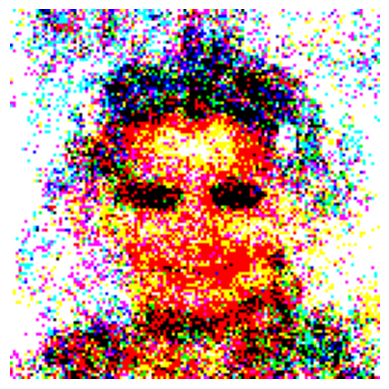

In [31]:
# Generar una imagen nueva
ruido = tf.random.normal(shape=[2, tamanio_codificacion])
imagen_generada = generador.predict(ruido)

print(len(imagen_generada))
# Visualizar la imagen generada
plt.imshow(imagen_generada[1])
plt.axis('off')
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         840705    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,053,570
Trainable params: 840,321
Non-trainable params: 213,249
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization

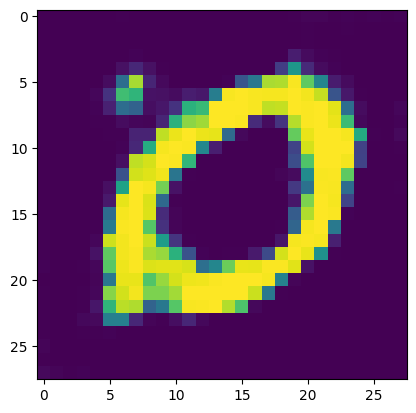

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

(X_entreno, y_entreno), (X_prueba, y_prueba) = mnist.load_data()

plt.imshow(X_entreno[0])

y_entreno

X_entreno = X_entreno/255

X_entreno.shape

X_entreno = X_entreno.reshape(-1, 28, 28, 1) * 2. - 1.

X_entreno.shape

X_entreno.min()

X_entreno.max()
n = 0
X_filtrado = X_entreno[y_entreno == n]
X_filtrado.shape
#En Jupyter NB funciona esto para ver una imagen
n = 0
plt.imshow(X_filtrado[n])
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
np.random.seed(42)
tf.random.set_seed(42)

# Tamaño de la capa que va hacia el 
#    Generador
tamanio_codificacion = 100
generador = Sequential()
generador.add(Dense(7 * 7 * 128, 
                    input_shape = [tamanio_codificacion]))
generador.add(Reshape([7, 7, 128]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(64, 
                              kernel_size = 5, 
                              strides = 2, 
                              padding = "same",
                              activation = "relu"))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(1, 
                              kernel_size = 5, 
                              strides = 2, 
                              padding = "same",
                              activation = "tanh"))
discriminador = Sequential()
discriminador.add(Conv2D(64, 
                         kernel_size = 5, 
                         strides = 2, 
                         padding = "same",
                         activation = LeakyReLU(0.3),
                         input_shape = [28, 28, 1]))
discriminador.add(Dropout(0.5))
discriminador.add(Conv2D(128, 
                         kernel_size = 5, 
                         strides = 2, 
                         padding = "same",
                         activation = LeakyReLU(0.3)))
discriminador.add(Dropout(0.5))
discriminador.add(Flatten())
discriminador.add(Dense(1, 
                        activation = "sigmoid"))
GAN = Sequential([generador, discriminador])
discriminador.compile(loss="binary_crossentropy", optimizer="adam")
discriminador.trainable = False
GAN.compile(loss = "binary_crossentropy", 
            optimizer = "adam")
GAN.layers

GAN.summary()
GAN.layers[0].summary()
GAN.layers[1].summary()

import tensorflow as tf
# Si se desea que el entrenamiento sea más
#   rápido, se puede tomar un valor mayor
tamanio_tanda = 32
# mis_datos = X_entreno
mis_datos = X_filtrado
datos = tf.data.Dataset.from_tensor_slices(mis_datos).shuffle(buffer_size = 1000)
type(datos)
datos = datos.batch(tamanio_tanda, 
                    drop_remainder = True).prefetch(1)
# Hay muchas mas capas y es mejor dar más 
#   tiempo para entrenar...por eso puede 
#   ser necesario trabajar con GPUs
epocas = 20
# Tomar los componentes por separado
generador, discriminador = GAN.layers
for epoca in range(epocas):
    print(f"Voy por la época {epoca + 1}")
    i = 0
    # Para cada tanda en el conjunto de datos
    for X_tanda in datos:
        i = i + 1
        if i % 25 == 0:
            print(f"\tVoy por la tanda número {i} de {len(mis_datos) // tamanio_tanda}")
            
        ##############################################
        ## Fase 1 - Entrenamiento del DISCRIMINADOR ##
        ##############################################
        
        # Crear Ruido
        ruido = tf.random.normal(shape = [tamanio_tanda, 
                                          tamanio_codificacion])
        
        # Generar imágenes falsas (números) basadas sólo en una entrada de ruido
        # Notar que el Generador nunca vé imágenes reales (solo ruido)
        imagenes_gen = generador(ruido)
        
        # Concatenar las Imágenes Generadas con las Verdaderas
        # Para poder utilizar tf.concat, los tipos de los datos deben
        #    coincidir!
        X_falso_vs_real = tf.concat([imagenes_gen, 
                                     tf.dtypes.cast(X_tanda,
                                                    tf.float32)], 
                                    axis = 0)
        
        # Las metas se fijan en cero (0) para imágenes falsas 
        #     y uno (1) para imágenes reales
        y1 = tf.constant([[0.]] * tamanio_tanda + [[1.]] * tamanio_tanda)
        
        # La siguiente instrucción obvia una advertencia de Keras
        discriminador.trainable = True
        
        # Entrenar al discriminador con esta tanda
        discriminador.train_on_batch(X_falso_vs_real, y1)
        
        
        ##########################################
        ## Fase 2 - Entrenamiento del GENERADOR ##
        ##########################################
        
        # Crear algo de ruido
        ruido = tf.random.normal(shape=[tamanio_tanda, 
                                        tamanio_codificacion])
        
        # Se quiere que el discriminador crea 
        #   que las imágenes falas son reales
        y2 = tf.constant([[1.]] * tamanio_tanda)
        
        # Evitar una advertencia
        discriminador.trainable = False
        
        GAN.train_on_batch(ruido, y2)
        
print("Entrenamiento Completado")            

#Ahora que está todo entrenado, se puede probar solo el generador para producir imágenes**
ruido = tf.random.normal(shape = [10, tamanio_codificacion])
ruido.shape
plt.imshow(ruido)
imagenes = generador(ruido)
plt.imshow(imagenes[0])